In [1]:

import os
import zipfile
import datetime
from collections import Counter
import tensorflow_hub as hub
import sklearn
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import models,layers
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
import matplotlib.pyplot as plt
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import cv2

# Data Directory

In [2]:
img_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'


In [3]:
covid_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/COVID-1.png')      
Normal_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/Normal-1.png')
pneumonia_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1.png')  
Lung_image=cv2.imread('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1.png')

# Image Show of All classes

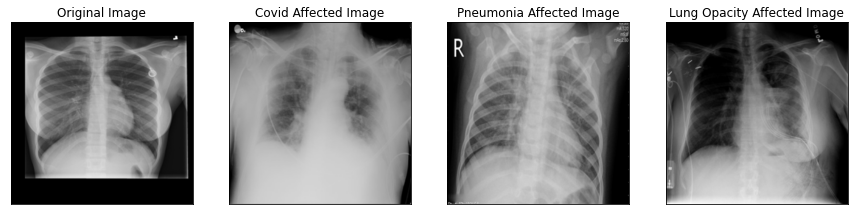

In [4]:
titles = ['Original Image', 
            'Covid Affected Image', 'Pneumonia Affected Image', 'Lung Opacity Affected Image']
images = [Normal_image,covid_image, pneumonia_image,Lung_image]

plt.figure(figsize=(15,7))
for i in range(0,4):
    plt.subplot(1,4,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

# Input Size

In [5]:
BATCH_SIZE =32
IMAGE_SIZE = 224
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)

# Data Appending

In [6]:
list_files = []
for dir in os.listdir(img_path):
  aux_dir = os.path.join(img_path,dir)
  
  if os.path.isdir(aux_dir):
    for img in os.listdir(aux_dir):
      list_files.append([os.path.join(dir,img),dir])
df = pd.DataFrame(list_files, columns=['id','label'])
df.describe()

,id,label
count,21165,21165
unique,21165,4
top,Normal/Normal-4415.png,Normal
freq,1,10192


# Frequency Counting

In [7]:
def frequency_plot(df):
  freq_abs = Counter(df.label);
  freq_a = pd.DataFrame.from_dict(freq_abs, orient='index').reset_index()
  total = len(df.index)
  freq_r = freq_a[0]/total
  freq_a[1] = freq_r
  freq_a.columns = ['Label','Frequência absoluta','Frequência relativa']
  return freq_a
frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,Normal,10192,0.481550
1,Lung_Opacity,6012,0.284054
2,Viral Pneumonia,1345,0.063548
3,COVID,3616,0.170848


# Data Balancing

In [8]:
def balance_dataset(focus_class, df):
  classes = df.label.unique()
  classes_df_list = []
  focus_class_df = df[df.label == focus_class]
  classes_df_list.append(focus_class_df)
  count_focus_class = len(focus_class_df)
  ##Divide by class
  for classe in classes:
    class_df = df[df.label == classe]
    count_class = len(class_df)
    if classe == focus_class:
      continue
    if count_class > count_focus_class+500:
      class_df = class_df.sample(count_focus_class+500)
    classes_df_list.append(class_df)
  df_under = pd.concat(classes_df_list, axis=0) 
  return df_under


df = balance_dataset('COVID',df)

frequency_plot(df)

,Label,Frequência absoluta,Frequência relativa
0,COVID,3616,0.274085
1,Normal,4116,0.311984
2,Lung_Opacity,4116,0.311984
3,Viral Pneumonia,1345,0.101948


# Test,Validation,Training Spliting

In [9]:
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['label']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['label'][train_index], df['label'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf

#divide train/val/test in 80/10/10
traindf,testdf = split_dataset(df,test_size = 0.25)
valdf,testdf= split_dataset(testdf,test_size = 0.50)
# traindf = balance_dataset('COVID',df)


traindf.id = img_path + traindf.id
valdf.id = img_path + valdf.id
testdf.id = img_path + testdf.id

# Frequency Ploting

In [10]:
frequency_plot(traindf)

,Label,Frequência absoluta,Frequência relativa
0,Normal,3087,0.312007
1,Viral Pneumonia,1008,0.101880
2,Lung_Opacity,3087,0.312007
3,COVID,2712,0.274106


# Data Generator

In [11]:

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range = 0.2,
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)


print("Creating train generator...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=traindf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)


val_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=testdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    color_mode="rgb",
    seed=5,
    shuffle = False,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

print("\nCreating val generator...")
val_generator = val_datagen.flow_from_dataframe(
    dataframe=valdf,
    directory="COVID-19_Radiography_Dataset",
    x_col="id",
    y_col="label",
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    seed=5,
    shuffle=True,
    class_mode="categorical",
    target_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Creating train generator...
Found 9894 validated image filenames belonging to 4 classes.
Found 1650 validated image filenames belonging to 4 classes.

Creating val generator...
Found 1649 validated image filenames belonging to 4 classes.


In [12]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

# CNN Model

In [13]:
model = Sequential()


model.add(Conv2D(64, (3, 3),activation='relu', input_shape=(224,224,3)))
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(strides=2,pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(strides=2,pool_size=(2, 2)))


model.add(Conv2D(256, (3, 3),activation='relu'))
#model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(strides=2,pool_size=(2, 2)))


model.add(Conv2D(512, (3, 3),activation='relu'))
model.add(Conv2D(512, (3, 3),activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(strides=2,pool_size=(2, 2)))

    
model.add(Flatten())


model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax',))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 512)       1

# Create CheckPoint

In [14]:
checkpoints_path = '/kaggle/output/models_checkpoints/covid_project'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoints_path,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
#to avoid overfitting
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=7)
mcp_save = tf.keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Model Compile

In [15]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00001),  loss='categorical_crossentropy',
              metrics=METRICS)
callbacks = [model_checkpoint_callback,early,mcp_save]

# Fit Model  

In [16]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch =len( train_generator),
    epochs=100,
    callbacks=callbacks,
    validation_data = val_generator,
    validation_steps=BATCH_SIZE,
    verbose=1)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
310/310 [==============================] - 382s 1s/step - loss: 1.3577 - accuracy: 0.2999 - precision: 0.2696 - recall: 4.0277e-04 - val_loss: 1.3080 - val_accuracy: 0.3174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
310/310 [==============================] - 368s 1s/step - loss: 1.2951 - accuracy: 0.3407 - precision: 0.4141 - recall: 0.0112 - val_loss: 1.0554 - val_accuracy: 0.5283 - val_precision: 0.6250 - val_recall: 0.1953
Epoch 3/100
310/310 [==============================] - 368s 1s/step - loss: 1.1129 - accuracy: 0.4824 - precision: 0.5902 - recall: 0.2160 - val_loss: 0.9214 - val_accuracy: 0.6016 - val_precision: 0.6889 - val_recall: 0.4043
Epoch 4/100
310/310 [==============================] - 368s 1s/step - loss: 0.9911 - accuracy: 0.5674 - precision: 0.6545 - recall: 0.3696 - val_loss: 0.8428 - val_accuracy: 0.6357 - val_precision: 0.6938 - val_recall: 0.4736
Epoch 5/100
310/310 [==============================] - 368s 1s/step - loss: 0.8947 -

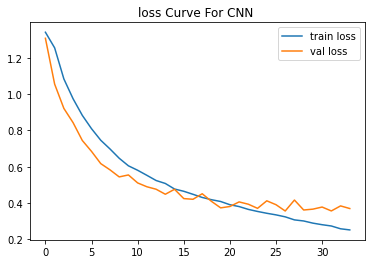

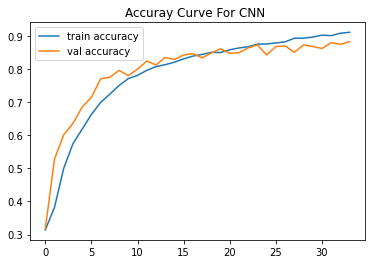

<Figure size 432x288 with 0 Axes>

In [17]:

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
model.save("my_model_CNN.h5")
plt.title("loss Curve For CNN ")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title("Accuray Curve For CNN ")
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

#Testing

In [18]:
model.evaluate(test_generator)

52/52 [==============================] - 57s 1s/step - loss: 0.4090 - accuracy: 0.8691 - precision: 0.8804 - recall: 0.8564


[0.4090413749217987,
 0.8690909147262573,
 0.8803738355636597,
 0.8563636541366577]

# Accuracy Measurement

In [19]:
from sklearn.metrics import classification_report

test_pred_raw = model.predict(test_generator)
test_labels = np.asarray(test_generator.classes)
test_pred = np.argmax(test_pred_raw, axis=1)

class_names = list(test_generator.class_indices.keys())
print(classification_report(test_labels, test_pred))
print(test_generator.class_indices)

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       452
           1       0.85      0.85      0.85       515
           2       0.86      0.82      0.84       515
           3       0.92      0.95      0.93       168

    accuracy                           0.87      1650
   macro avg       0.88      0.88      0.88      1650
weighted avg       0.87      0.87      0.87      1650

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


# Confusion Matrix

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix CNN',
                          cmap=None,
                          normalize=True):
    

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
      cm = cm / np.expand_dims(cm.sum(axis=1),axis=1)
        # cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      pass

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

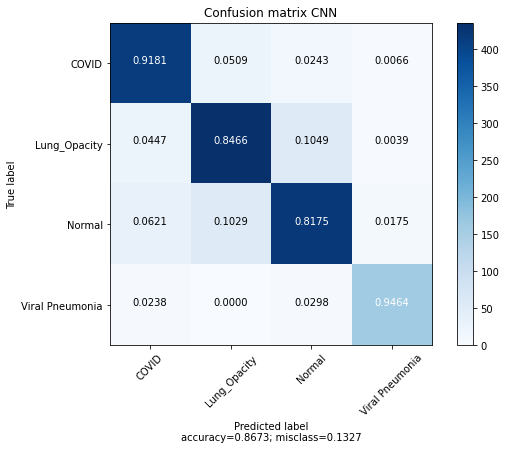

In [21]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
plot_confusion_matrix(cm,class_names)